## Notes on features to choose:

### From Kaggle Kernels:
#### Extensive Sberbank Exploratory Analysis:
**source:** https://www.kaggle.com/captcalculator/a-very-extensive-sberbank-exploratory-analysis/comments#latest-185178

* 37 observations where life_sq is greater than full_sq.
* A vast majority of the apartments have three rooms or less.
* Look to see how life sq ~ price changes based on sub-area or distance to kremlin
* Home price does seem to increase with population density.
* There does not appear to be a relationship between the mean home price in a district and the district’s share of working age population.
* Surprisingly, there is little to no correlation between price and the school variables. The school variables however are highly correlated with each other, indicating that we would not want to use all of them in a linear regression model due to multicollinearity.
* homes with >3 top 20 universities show signs of correlation, but only one house fits that description.
* raions that have a top 25 cultural object have a median home sale price that is higher by 1.2 million (using this feature as a factor)
* strong positive correlation between sport_objects_raion and price_doc

#### Simple Exploration Notebook - Sberbank
**source:** https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-sberbank/comments/notebook

* overall increasing trend in price as floor_num increases. A sudden increase in the house price is also observed at floor 18.
* Individual houses seems to be costlier, check price of 0 floor houses.

#### Map visualizations with external shapefile
**source:** https://www.kaggle.com/jtremoureux/map-visualizations-with-external-shapefile/notebook

* replace regions with map shapefile coordinates



### Functions for Scaling/Normalizing/Reshaping

In [32]:
# rescale data using the mean and sd 
def rescale(feature):
    return feature.apply(lambda x: (x - np.mean(x))/np.std(x))

# # normalize data
# from sklearn.preprocessing import Normalizer

def normalize(feature):
    return feature.apply(lambda x: (x-np.min(x))/(np.max(x)-np.min(x)))

### Functions for Rolling Statistics on Time-Series

In [1]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12,center=False).mean()
    rolstd = timeseries.rolling(window=12,center=False).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print 'Results of Dickey-Fuller Test:'
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print dfoutput

/Users/rezarad/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### Things to Consider/Reminders:
* housing market is influenced by the economy, but regions can become "hot" leading to overpriced properties.
* find or create one feature for every type of measurement that a set of similar features is representing (ie. one feature/meta-feature for location, one for size of unit, etc.) 

### Pipeline To Do:
* Look into kriging regression model for geospatial features
* Plot price to gender/age/subregion.
* subregions
    * linear reg to predict price just with subregion and size
    * mean/sd/var/median. 
    * see how well you can predict the sub-region by using price and size of home as features. 
    * max floors vs. price per subregion
* Look into Agglomerate features (merging two similar features)

## Import Libraries & Data

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
import matplotlib.patches as mpatches
import seaborn as sns
from scipy import stats
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn import svm
import statsmodels.api as sm
import statsmodels.formula.api as smf

%matplotlib inline

colors = sns.crayon_palette(['Tickle Me Pink', 'Atomic Tangerine', 'Fuzzy Wuzzy'])

In [3]:
df = pd.read_csv("./merged_w_state_build_year_2017-05-28.csv", parse_dates=['timestamp'], index_col=False)

In [28]:
gdp_feats = ['gdp_quart_growth', 'gdp_quart', 'balance_trade_growth',
            'cpi', 'deposits_growth', 'ppi', 
            'balance_trade', 'micex_rgbi_tr', 'rts', 'micex', 'brent', 
            'eurrub', 'usdrub', 'micex_cbi_tr', 
            'fixed_basket','oil_urals', 'full_sqrt']

gdp_df = df[gdp_feats].dropna()

In [29]:
important_features = ['id', 'full_sq', 'life_sq', 'floor',
                      'max_floor', 'material', 'build_year',
                      'num_room', 'kitch_sq', 'state', 'area_m',
                      'price_doc', 'gdp_quart', 'deposits_value', 
                      'deposits_growth', 'deposits_rate', 'mortgage_value',
                      'mortgage_growth', 'mortgage_rate', 'salary',
                      'unemployment', 'employment',  'oil_urals',
                      'stadium_km', 'floor', 'max_floor', 'metro_min_avto',
                      'build_year', 'cafe_count_5000_price_high', 'num_room',
                      'radiation_km',
                      'green_zone_km', 'industrial_km', 'indust_part',
                      'cpi', 'cafe_count_5000', 'cafe_count_1500_price_high',
                      'cafe_count_5000_price_500', 'cafe_count_2000_price_2500',
                      'kitch_sq', 'max_floor', 'trc_sqm_5000', 
                      'office_sqm_1000', 'trc_sqm_1500', 'office_sqm_500', 'cpi', 
                      'office_sqm_5000', 'ID_railroad_terminal', 'office_sqm_1500', 
                      'ekder_male', 'raion_popul', 'price_doc']

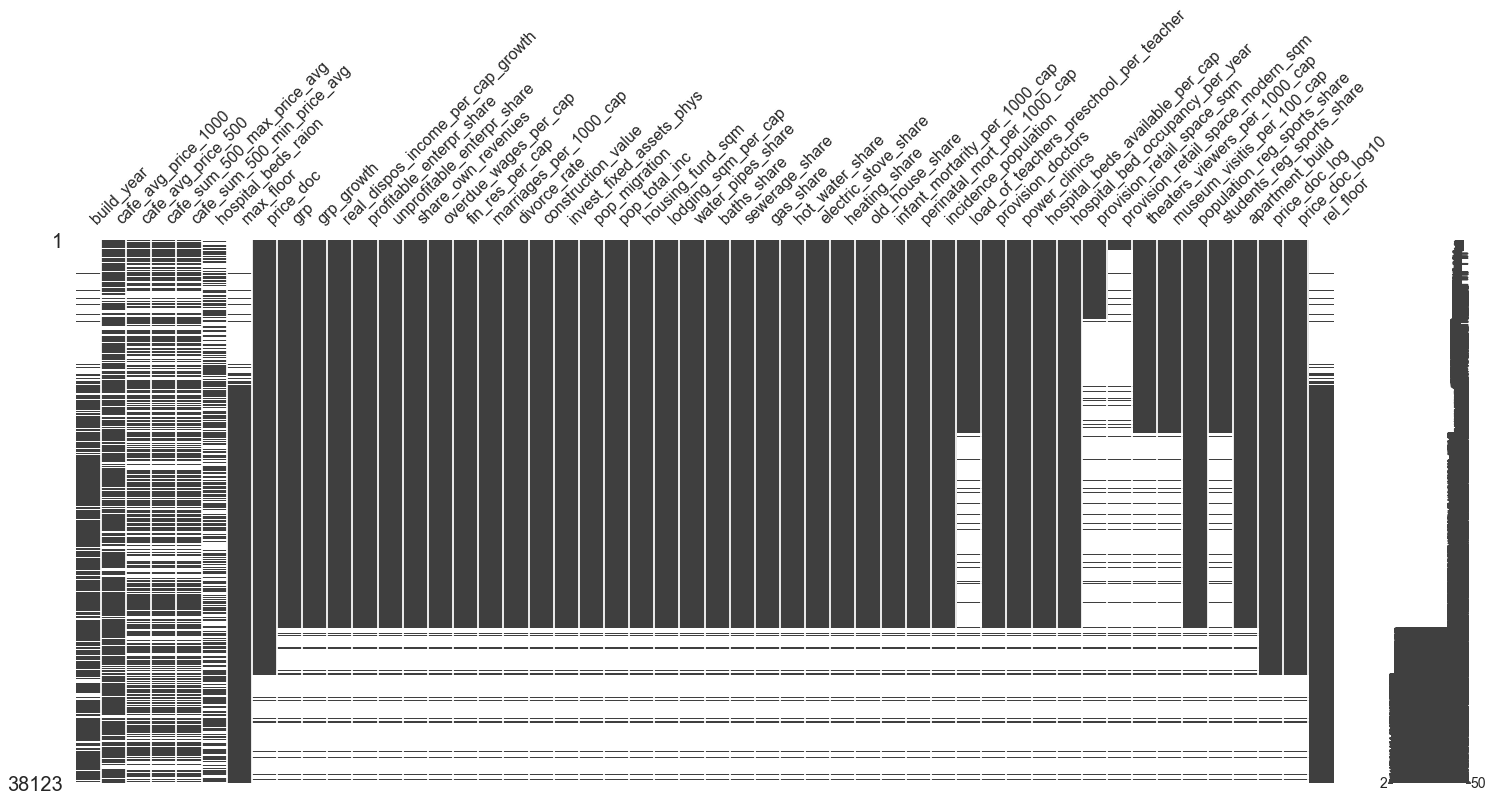

In [30]:
import missingno as msno

df.set_index('timestamp')
filtered_data = msno.nullity_filter(df, filter='bottom', n=50, p=0.99) # or filter='top'

msno.missingno.matrix(filtered_data)

#### Distribution of different GDP Features

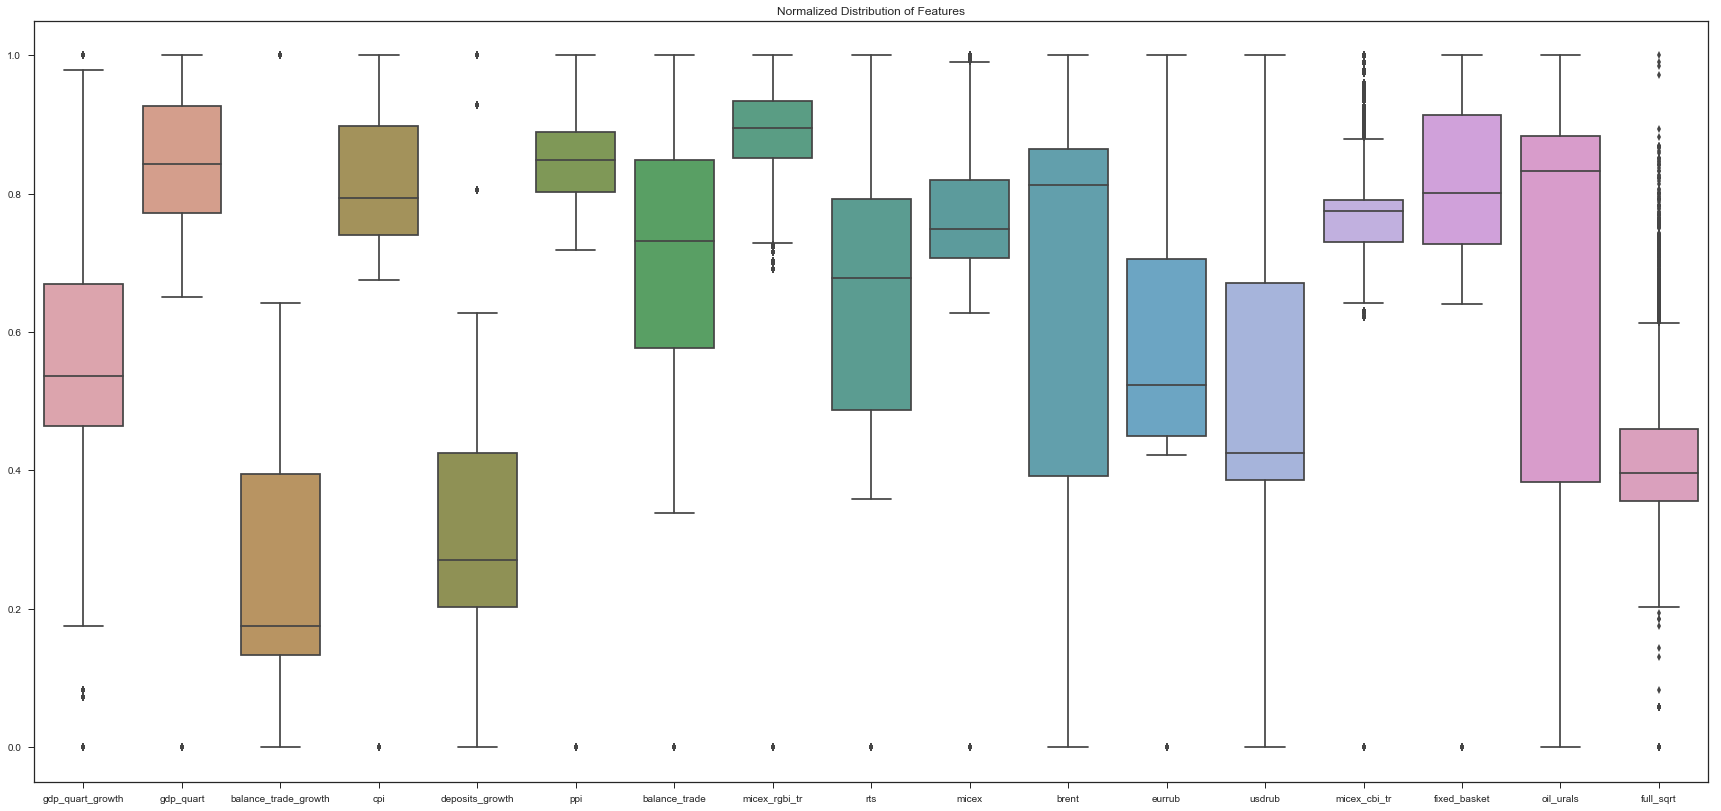

In [33]:
plt.figure(figsize=(30,14))
plt.title('Normalized Distribution of Features')
sns.set_style("ticks")
sns.boxplot(normalize(gdp_df),saturation=0.5) # plot scale
plt.show()

### Any relationships between the variables?

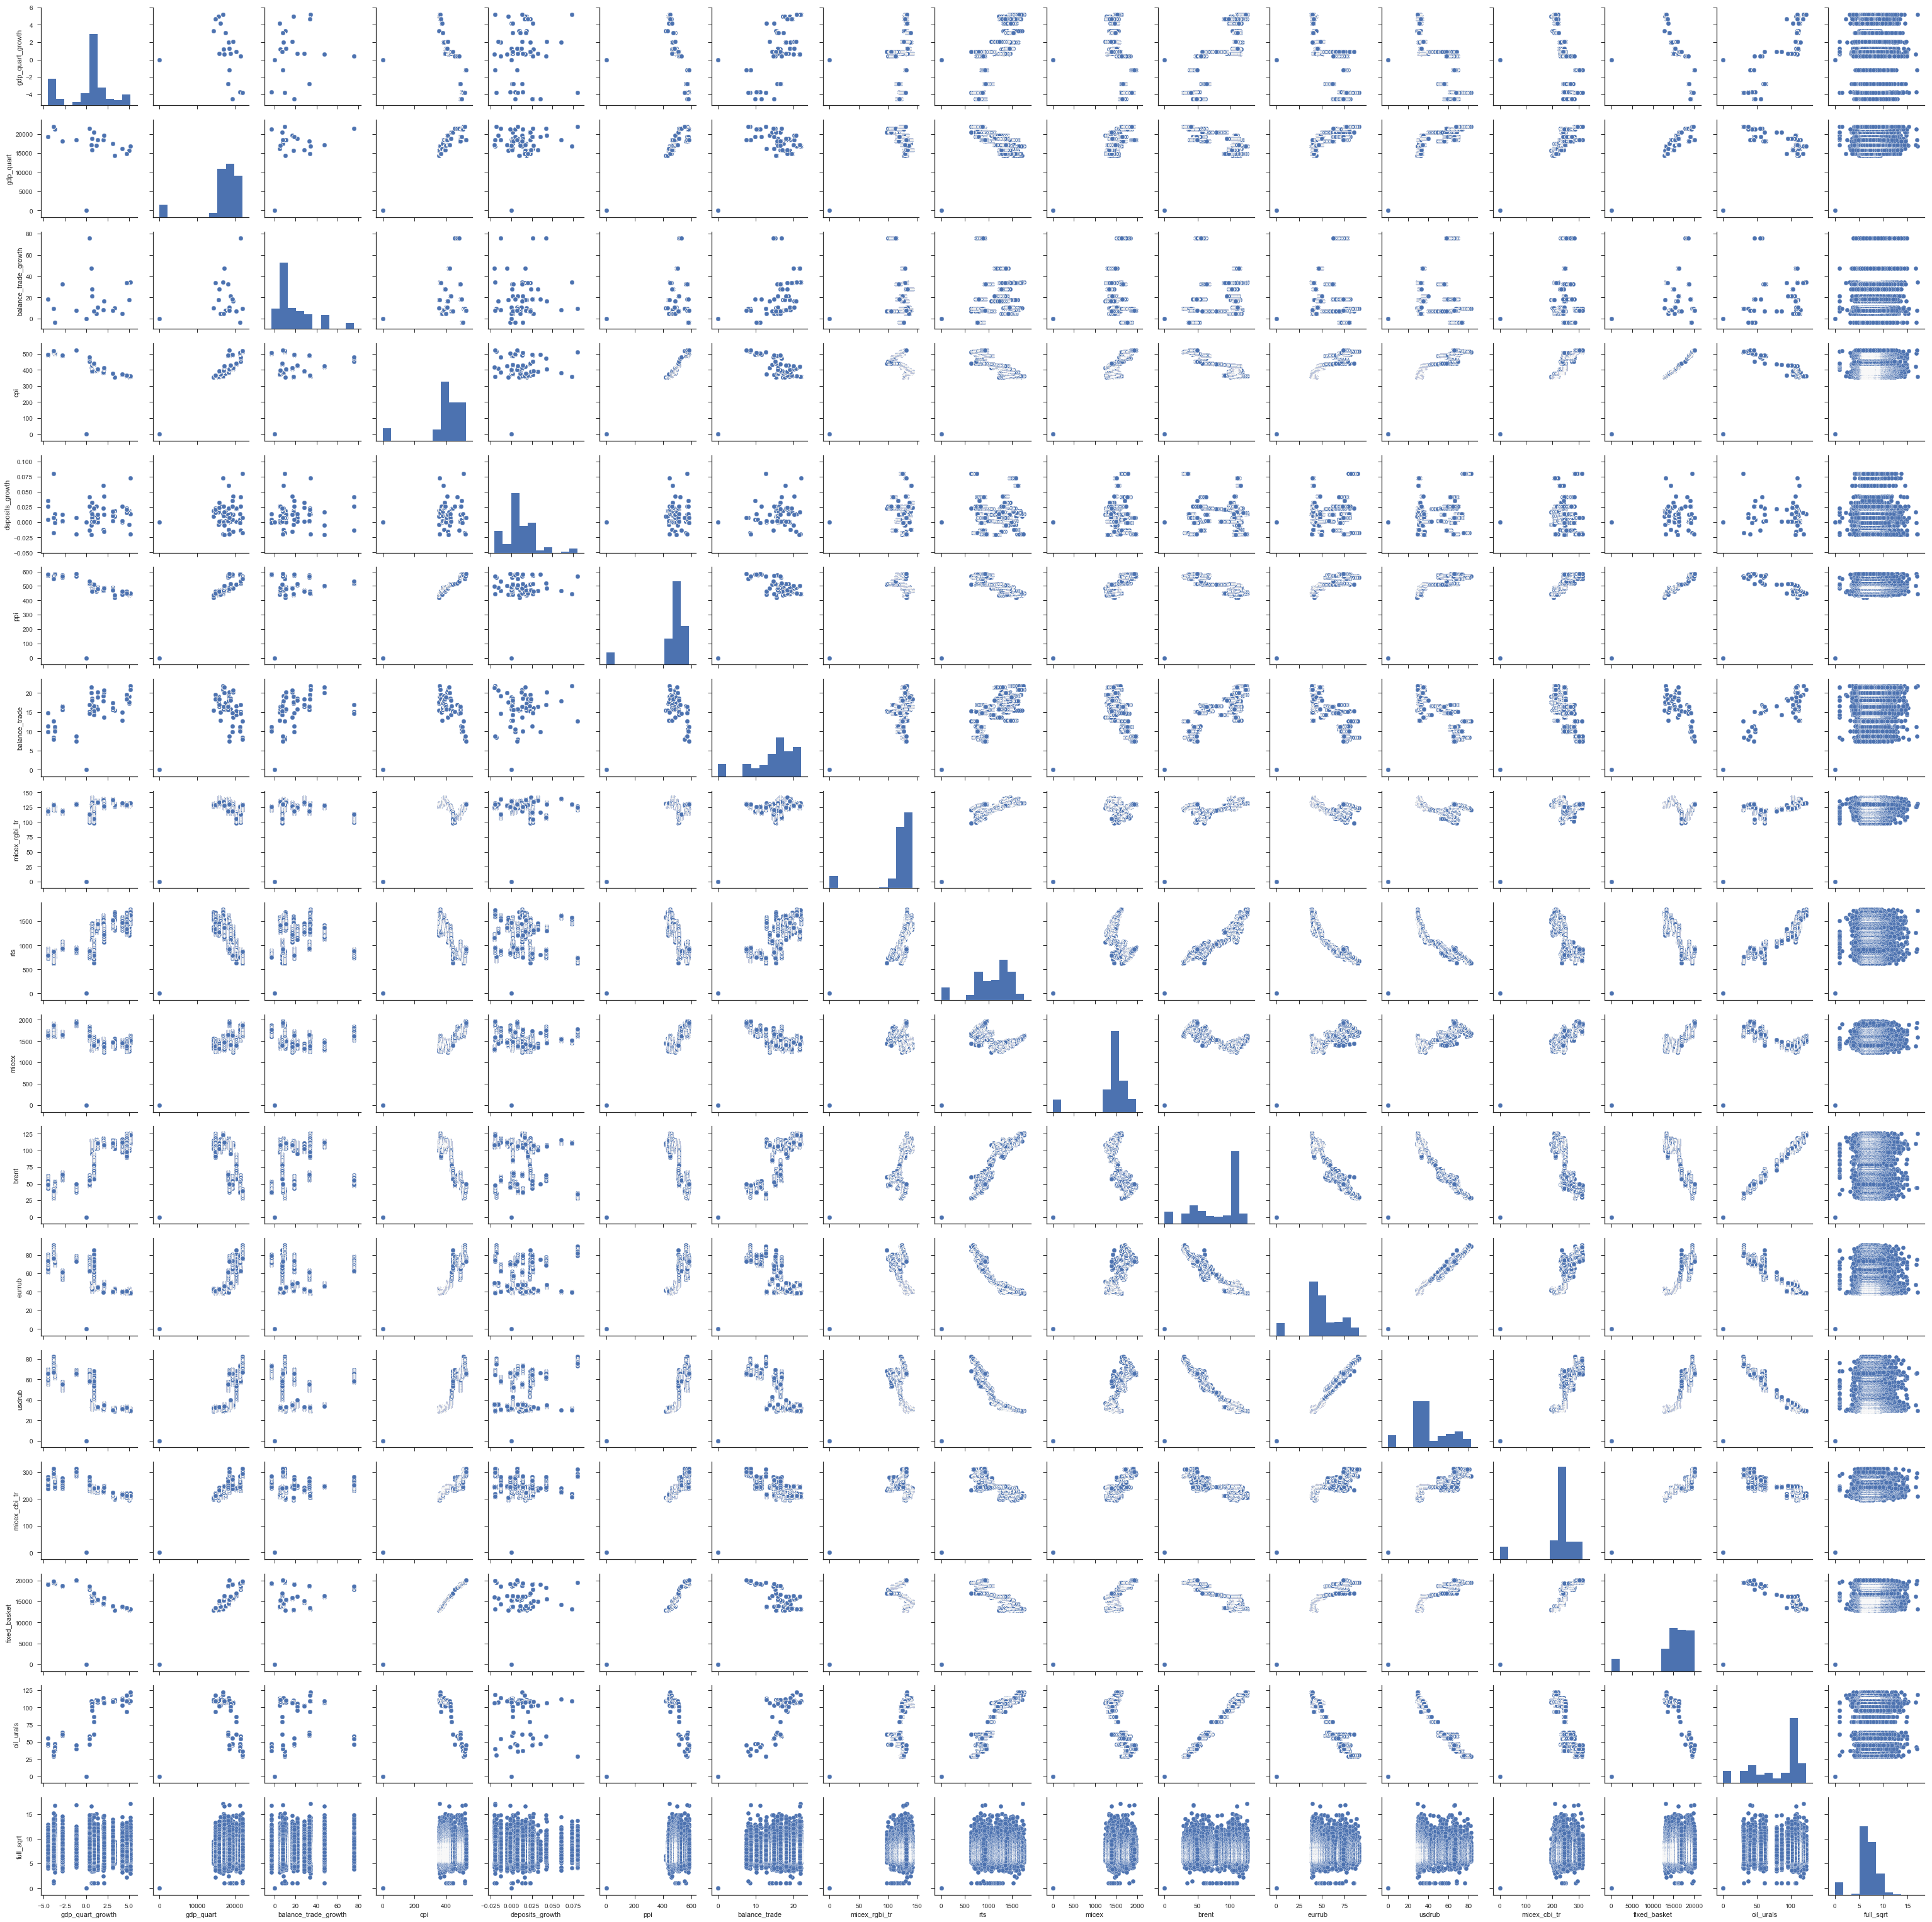

In [34]:
sns.pairplot(gdp_df)

In [126]:
# feature correlation per day with imputed medians
feature_corr = abs(gdp_df.corr()['price_doc']).sort_values(ascending=False) 

## Time-Series Analysis

In [121]:
print 'Start Date for Null gdp_quart: {0}'.format(macro_df.loc[macro_df['gdp_quart'].isnull(), 'timestamp'].min())
print 'End Date for Null gdp_quart: {0}'.format(macro_df.loc[macro_df['gdp_quart'].isnull(), 'timestamp'].max())

Start Date for Null gdp_quart: 2010-01-01 00:00:00
End Date for Null gdp_quart: 2010-03-31 00:00:00


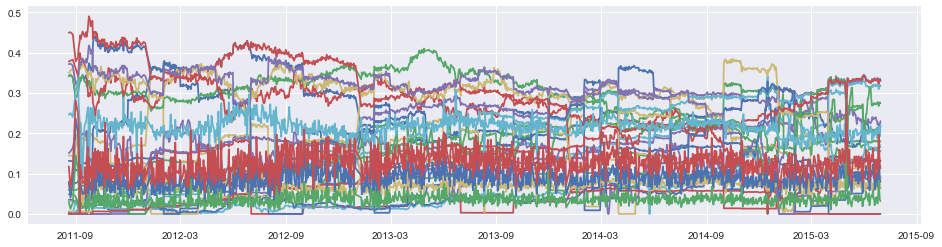

In [200]:
plt.figure(figsize=(16, 4))
plt.plot(norm_gdp)
plt.show()

This needs to be cleaned up with rolling mean windows

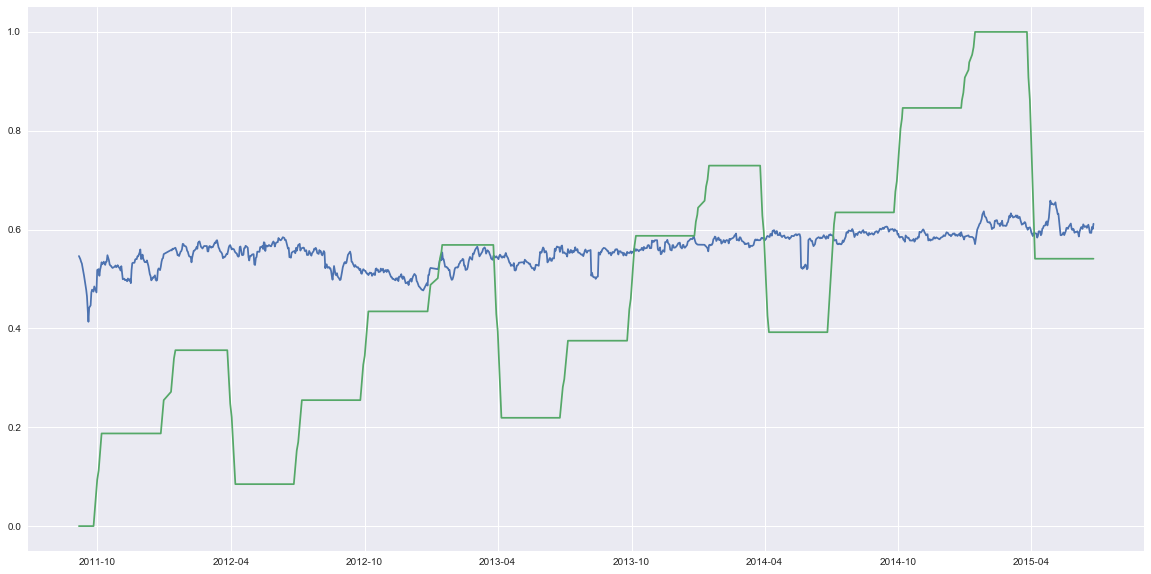

In [237]:
plt.figure(figsize=(20, 10))
plt.plot(gdp_rolling['price_doc_log'])
plt.plot(gdp_rolling['gdp_quart'])
sns.despine()
plt.show()

### Price smoothed out to better find trends

In [211]:
gdp_rolling = gdp_df.rolling(window=10, center=True).mean()

/Users/rezarad/anaconda2/lib/python2.7/site-packages/matplotlib/legend.py:634: UserWarning: Legend does not support <matplotlib.axes._subplots.AxesSubplot object at 0x178d187d0> instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#using-proxy-artist
  "#using-proxy-artist".format(orig_handle)


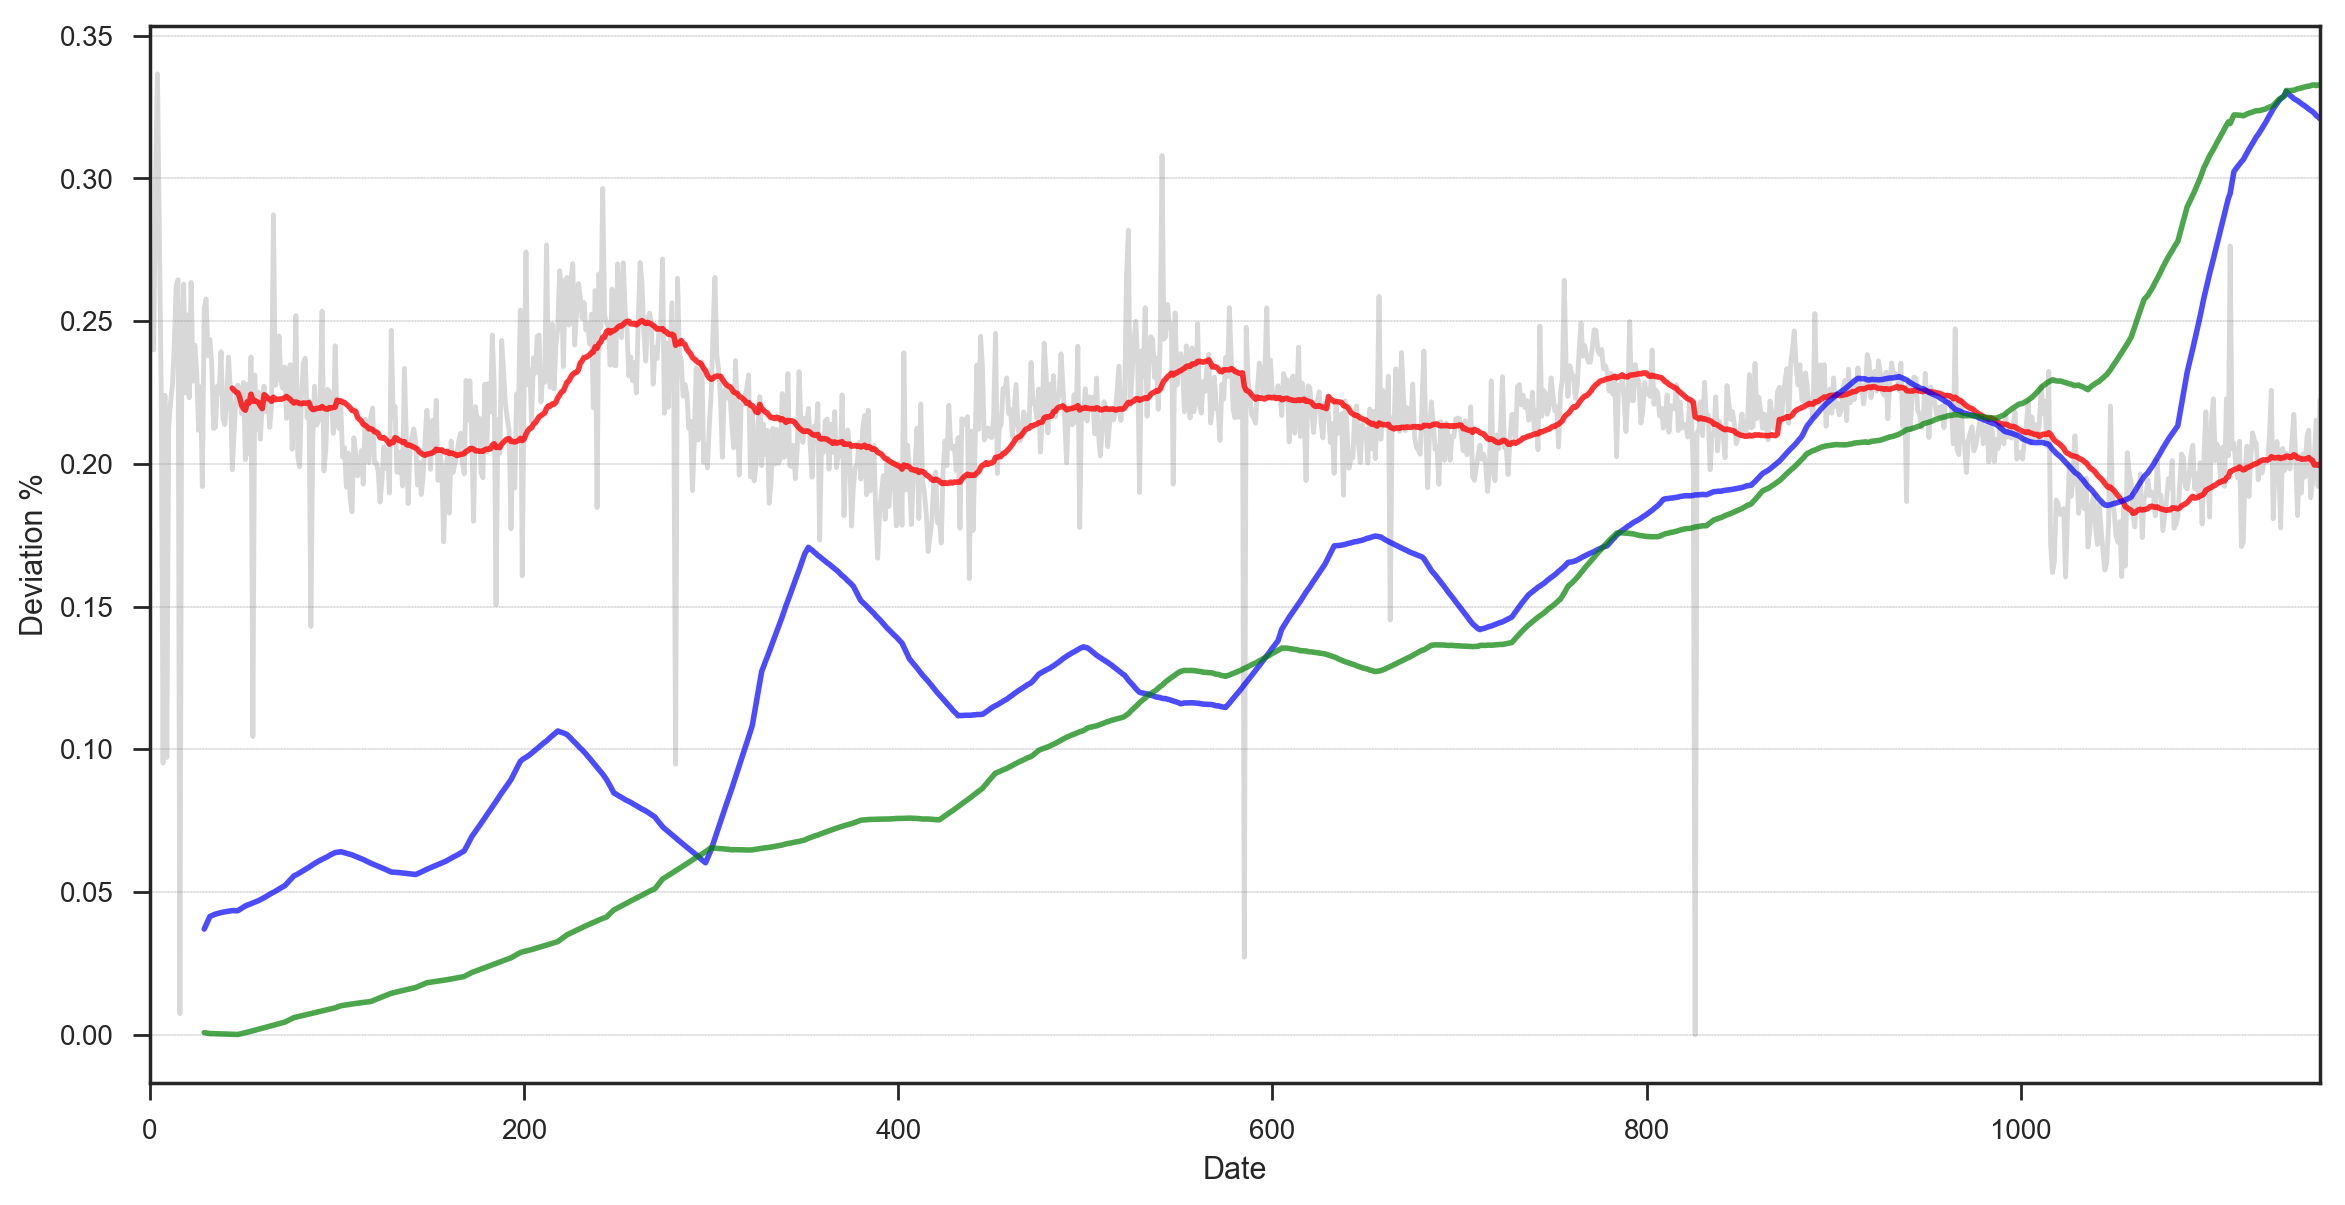

In [425]:
ts_log = norm_gdp['price_doc_log']

moving_avg = ts_log.rolling(window=45).mean()

# handles, labels = ax.get_legend_handles_labels()
# ax.legend(handles, labels)



plt.figure(figsize=(14,7), dpi=200)
sns.set(style="ticks")
plt.xlabel('Date')
plt.xticks()
plt.ylabel('Deviation %')
line1 = sns.tsplot(norm_gdp['price_doc_log'], color='grey', alpha=0.3, legend=True)
line2 = sns.tsplot(moving_avg, color='red', alpha=0.8, lw=2)
line3 = sns.tsplot(norm_gdp['ppi'].rolling(window=30).mean(), lw=2, color='blue', alpha=0.7) 
line4 = sns.tsplot(norm_gdp['cpi'].rolling(window=30).mean(), lw=2, color='green', alpha=0.7)
# snplt.tsplot(norm_gdp['gdp_quart'], color='red')
plt.grid(False, 'major', 'y', ls='--', lw=.1, c='black')
plt.legend(handles=[line1, line2,line3, line4])
plt.show()


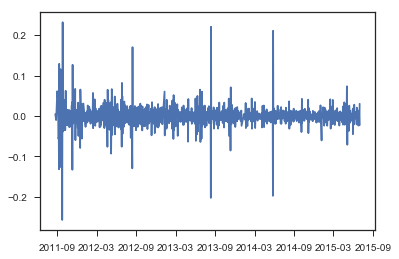

In [408]:
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)

### Log + 1 of CPI vs. PPI vs. Price

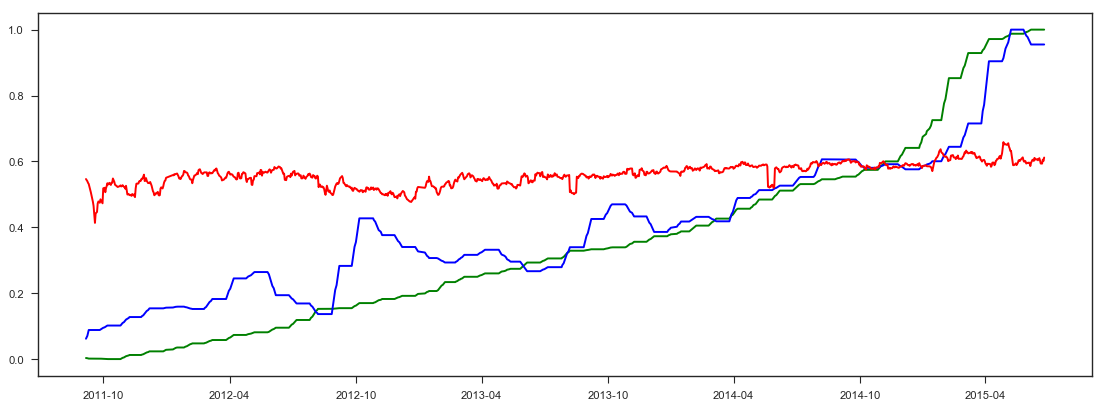

In [420]:
plt.figure(figsize=(17, 6),dpi=80)
plt.plot(gdp_rolling['cpi'], color='green')
plt.plot(gdp_rolling['ppi'], color='blue')
plt.plot(gdp_rolling['price_doc_log'], color='red')
plt.show()

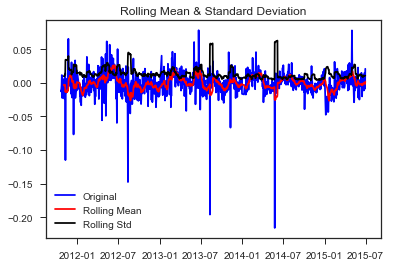

Results of Dickey-Fuller Test:
Test Statistic                -6.328855e+00
p-value                        2.940140e-08
#Lags Used                     9.000000e+00
Number of Observations Used    1.112000e+03
Critical Value (5%)           -2.864143e+00
Critical Value (1%)           -3.436244e+00
Critical Value (10%)          -2.568156e+00
dtype: float64


In [414]:
ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.head(120)
ts_log_moving_avg_diff.dropna(inplace=True)
test_stationarity(ts_log_moving_avg_diff)

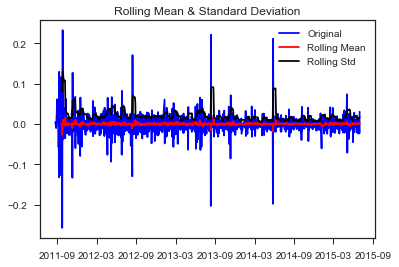

Results of Dickey-Fuller Test:
Test Statistic                -1.375336e+01
p-value                        1.040525e-25
#Lags Used                     1.600000e+01
Number of Observations Used    1.143000e+03
Critical Value (5%)           -2.864072e+00
Critical Value (1%)           -3.436084e+00
Critical Value (10%)          -2.568118e+00
dtype: float64


In [415]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

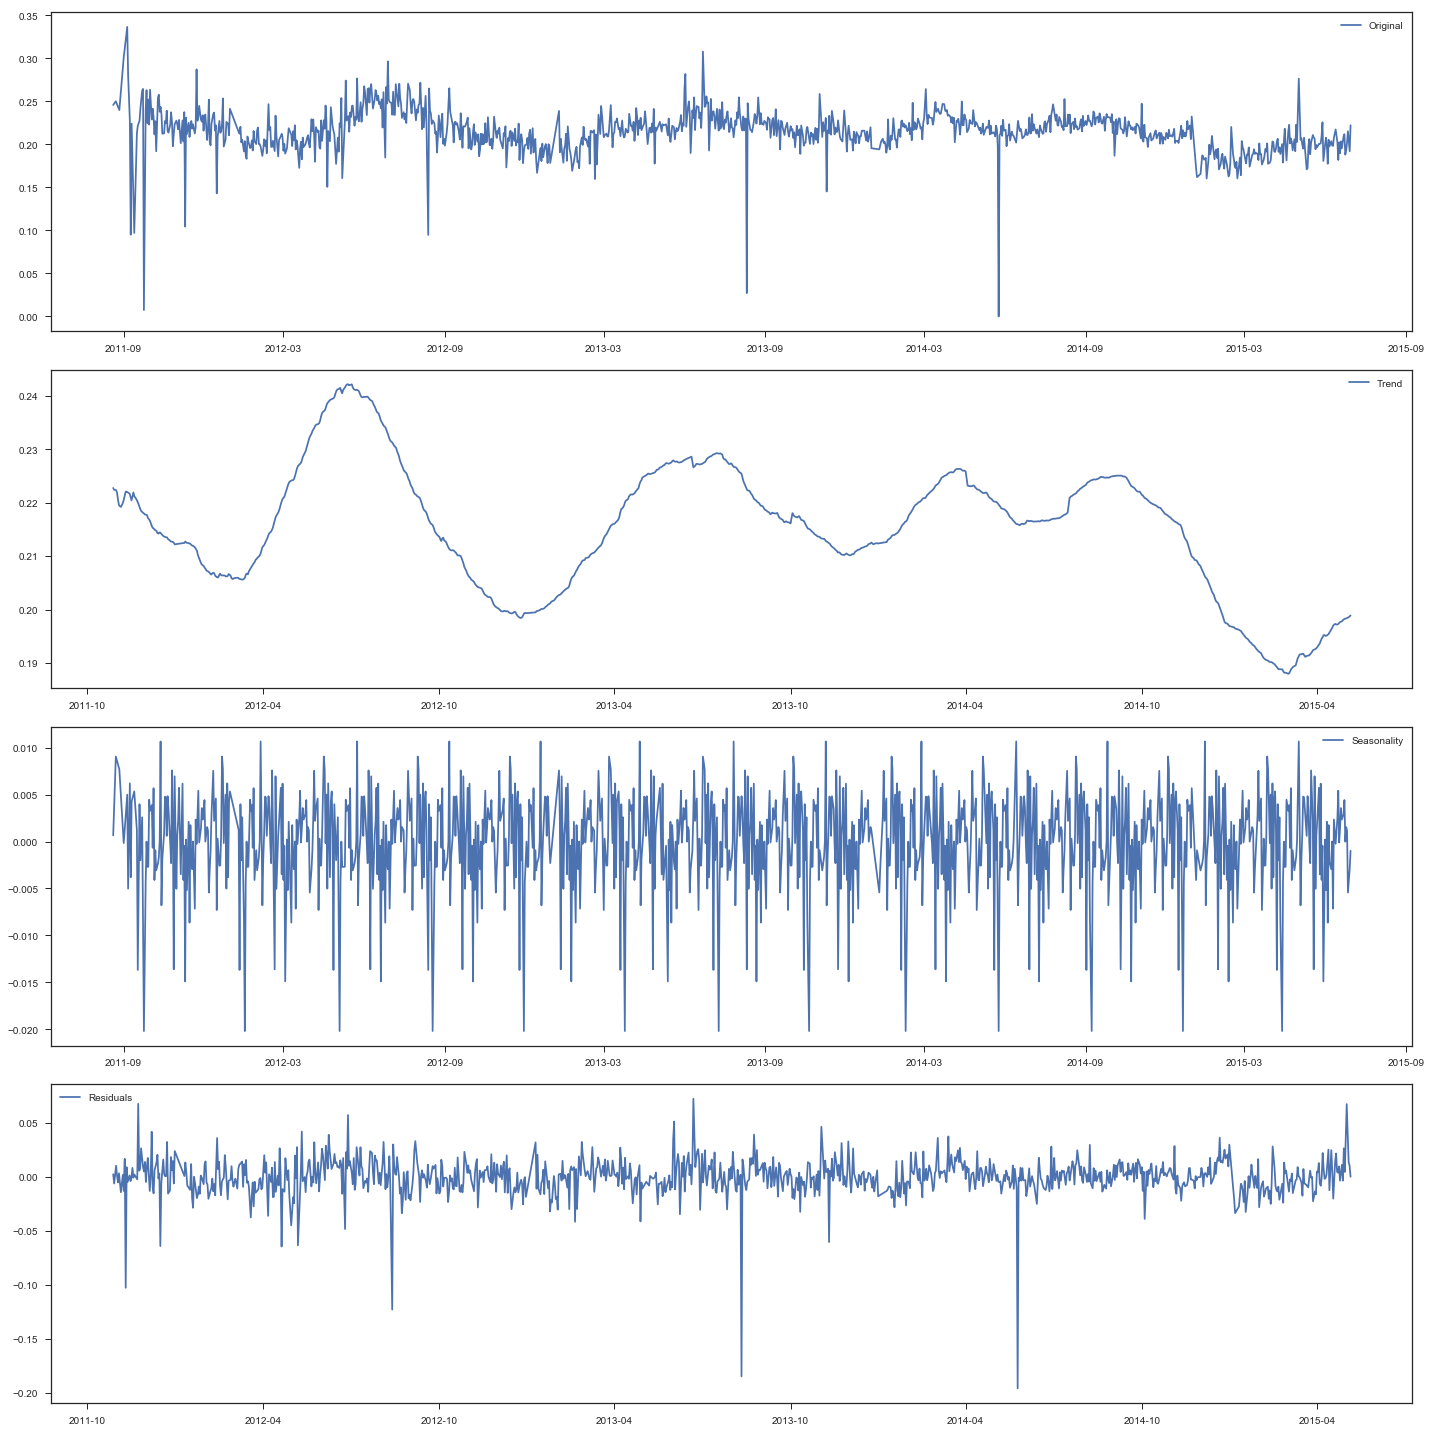

In [416]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, freq=90)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(20, 20))
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

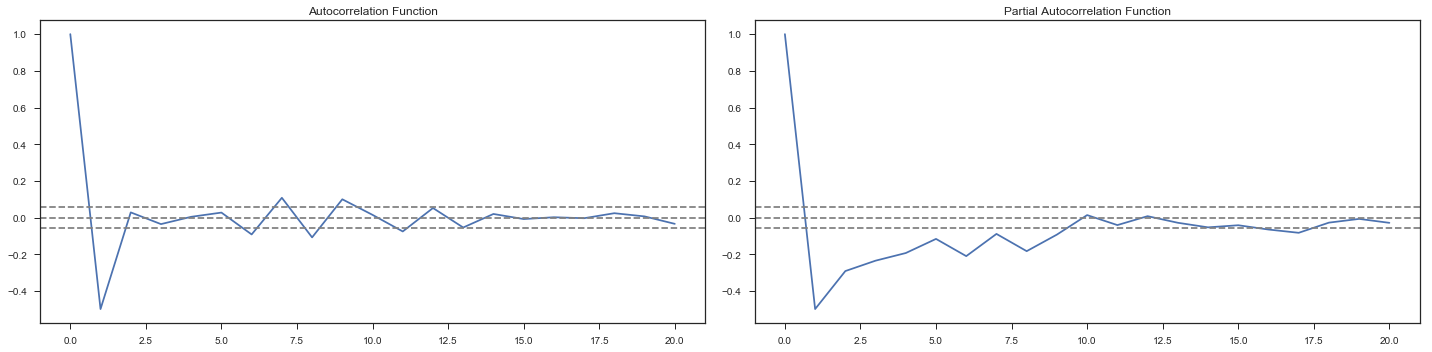

In [417]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(ts_log_diff, nlags=20)
lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')

#Plot ACF: 
plt.figure(figsize=(20,5))
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

/Users/rezarad/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


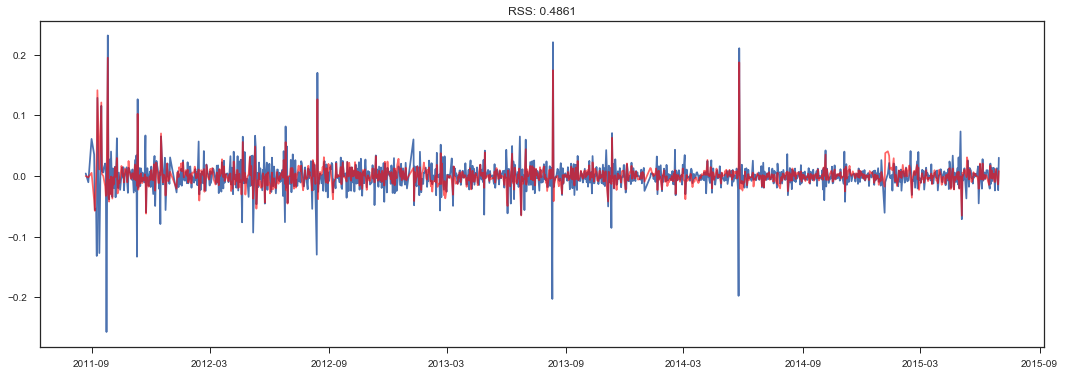

In [418]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(ts_log, order=(2, 1, 2))  
results_ARIMA = model.fit(disp=-1)  
plt.figure(figsize=(18,6))
plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red', alpha=0.6)
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))

Euro to Ruble has a slightly strong correlation, so let's remove USD for now.

### Euro to Ruble

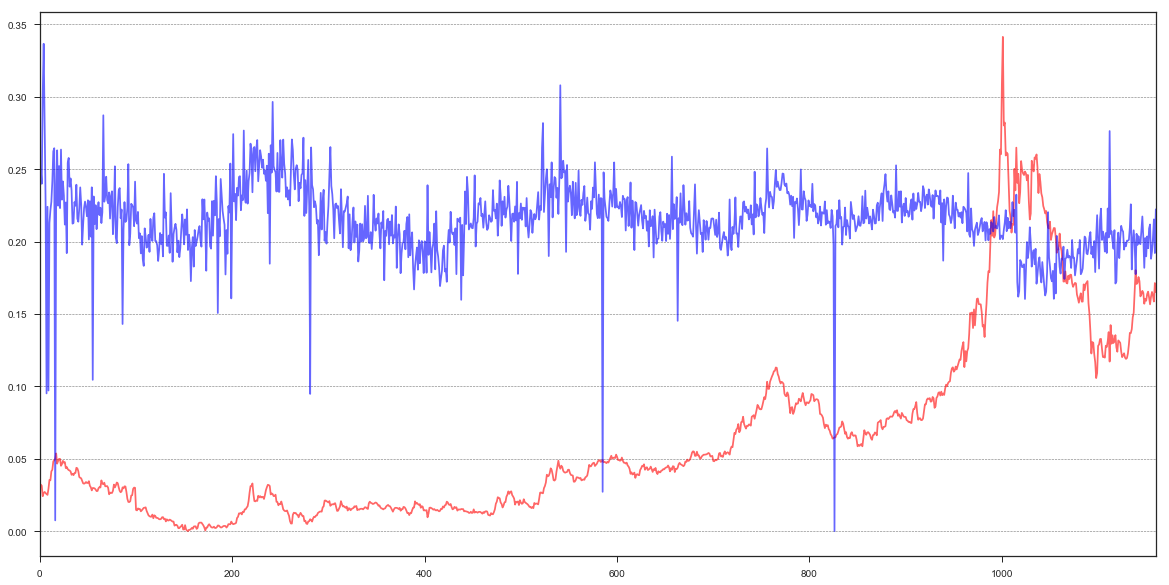

In [419]:
plt.figure(figsize=(20, 10))
sns.set_style("ticks")
sns.tsplot(norm_gdp['eurrub'], color='red', alpha=0.6)
plt.plot()
sns.tsplot(norm_gdp['price_doc_log'], color='blue', alpha=0.6, err_style='ci_band', ci=4)
plt.grid(False, 'major', 'y', ls='--', lw=0.6, c='gray')
plt.show()